In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from typing import Union

from dotenv import load_dotenv
load_dotenv(override=True)

from pydantic import BaseModel, Field
import requests
from io import BytesIO
from PIL import Image
import numpy as np
from plotreader.utils.structured_types.data import DataFrameRowsOnly
import pandas as pd
import seaborn as sns

import nest_asyncio
nest_asyncio.apply()

from llama_index.core.vector_stores.types import MetadataFilters, MetadataFilter, FilterOperator, FilterCondition
from llama_index.core.prompts import PromptTemplate
from llama_index.core.output_parsers.pydantic import PydanticOutputParser
from llama_index.core.schema import TextNode, IndexNode, NodeRelationship, RelatedNodeInfo, ImageNode
from llama_index.core.schema import ImageNode, NodeWithScore, MetadataMode


import plotreader
from plotreader.utils.document import ScientificPaperHandler
from plotreader.utils.base import BasicAnthropicLLM

In [3]:
claude_mm_default = BasicAnthropicLLM(model='claude-3-5-sonnet-20240620', temperature = 0.0)

In [4]:
handler = ScientificPaperHandler(
    filepath="/Users/loyalshababo/dev/plotreader/sandbox/storage/tmp/nihms-1538039.pdf",
    document_id = "3de6841c-fba6-4124-a28a-2c53124202af",
    # filepath="/Users/loyalshababo/dev/plotreader/sandbox/storage/tmp/s42003-021-01878-9.pdf",
    # document_id = "b562c2f2-b776-4829-b18c-6c6ebf4f788d",
    name="nihms-1538039",
    desc="A scientific paper",
    storage_dir = "./storage",
    use_cache = False
)

In [5]:
fig_num = 2

filters = MetadataFilters(filters=[
    MetadataFilter(
        key="fig_refs", 
        value=f'Figure {fig_num}',
        operator=FilterOperator.TEXT_MATCH_LIST
    # ),
    # MetadataFilter(
    #     key="fig_refs", 
    #     value='Figure 2d',
    #     operator=FilterOperator.TEXT_MATCH_LIST
    # ),
    # MetadataFilter(
    #     key="fig_refs", 
    #     value='Figure 2e',
    #     operator=FilterOperator.TEXT_MATCH_LIST
    )],
    condition=FilterCondition.OR
)

In [6]:
query_tool = handler.query_engine_tool(metadata_filters=filters)

In [7]:
class Variable(BaseModel):
    name: str
    categorical: bool

class Experiment(BaseModel):
    independent_variables: list[Variable]
    dependent_variables: list[Variable]

class Plot(BaseModel):
    name: str
    experiments: list[Experiment]

class Panel(BaseModel):
    name: str
    plots: list[Plot]

class Figure(BaseModel):
    name: str
    panels: list[Panel]
    # statistics: List[str]



In [8]:
output_parser = PydanticOutputParser(output_cls=Figure)

prompt = f"""
YOUR OVERALL JOB:
    You are an expert at extracting data from figures in scientific papers.
    You will always primarily look to the image of the figure.
    You will look to text to obtain more detail if necessary.
    When there is a discrepency between text and graphic, always defer to the graphic.

YOUR CURRENT TASK:
Complete the following task by visual inspection of the figure ONLY. Omit information if not available in the image.
For each plot in each panel of THE IMAGE of Fig. {fig_num}, determine the experiment in terms of Independent variables (IVs) and dependent variable (DV). 
By plot, we mean each set of axes or displays. Each panel can have multiple plots. See the json definition below for more.

Return your answer as structured data.
"""

prompt = PromptTemplate(prompt, output_parser=output_parser).format(llm=plotreader._MM_LLM)

In [9]:
response = query_tool(prompt)
nodes = response.raw_output.source_nodes
figure_struct = output_parser.parse(response.content)

In [10]:
nodes

[NodeWithScore(node=TextNode(id_='816f492a-fb49-4eab-8c9c-7c0a71364724', embedding=None, metadata={'Header_1': 'Online methods', 'Header_2': 'Light delivery and imaging', 'experimental_variable_entities': ['light pulse duration', 'wavelength', 'power', 'photocurrent strength', 'light intensity'], 'fig_refs': ['Supplemental Figure 5', 'Figure 2e']}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='a71f2164-f8f5-48e0-be2c-3f5484fb2c5d', node_type=<ObjectType.TEXT: '1'>, metadata={}, hash='7b659f8233a33154253211184f42d7c03aed827bbfd9936ed9ad29dfd80859c4'), <NodeRelationship.PARENT: '4'>: RelatedNodeInfo(node_id='d6122135-b264-4f4d-9724-1fa559a4f4cc', node_type=None, metadata={}, hash=None)}, text='Light delivery and imaging\n\nPatch-clamp recordings were done with short light pulses to measure photocurrents. Light pulse duration, wavelength, and power were varied depending on the experiment (as describe

In [11]:
# find figure image
for node in nodes:
    if isinstance(node.node, ImageNode):
        response = requests.get(node.node.image_url)
        source_figure = Image.open(BytesIO(response.content))
        source_figure_summary = node.node.text

In [12]:
fig_description = f"{figure_struct.name}"

for panel in figure_struct.panels:
    fig_description += f"\n\tPanel: {panel.name}\n"
    for plot in panel.plots:
        fig_description += f"\n\t\tPlot: {plot.name}"
        for experiment in plot.experiments:
            fig_description += f"\n\t\t\t{experiment}"

print(fig_description)

Figure 2
	Panel: a

		Plot: Current traces and cell images
			independent_variables=[Variable(name='ChR variant', categorical=True), Variable(name='Time', categorical=False)] dependent_variables=[Variable(name='Current', categorical=False), Variable(name='Fluorescence', categorical=False)]
	Panel: b

		Plot: Photocurrent strength
			independent_variables=[Variable(name='ChR variant', categorical=True), Variable(name='Wavelength', categorical=True)] dependent_variables=[Variable(name='Peak photocurrent', categorical=False), Variable(name='Steady-state photocurrent', categorical=False)]
	Panel: c

		Plot: Off-kinetics decay rate
			independent_variables=[Variable(name='ChR variant', categorical=True)] dependent_variables=[Variable(name='τoff', categorical=False)]
		Plot: Current traces inset
			independent_variables=[Variable(name='ChR variant', categorical=True), Variable(name='Time', categorical=False)] dependent_variables=[Variable(name='Current', categorical=False)]
	Panel: d

		Plot

In [13]:
# select panel d (only one plot in panel)
panel = figure_struct.panels[3]
plot = panel.plots[0]
exp = plot.experiments[0]

In [14]:
class BoundingBox(BaseModel):
    left_x: float = Field(default = 0.0, description="The x-coordinate of the left side of the bounding box in the range 0.0 to 1.0")
    upper_y: float = Field(default = 0.0, description="The y-coordinate of the top side of the bounding box in the range 0.0 to 1.0")
    right_x: float = Field(default = 1.0, description="The x-coordinate of the right side of the bounding box in the range 0.0 to 1.0")
    lower_y: float = Field(default = 1.0, description="The y-coordinate of the bottom side of the bounding box")

In [15]:
output_parser = PydanticOutputParser(output_cls=BoundingBox)

In [16]:
PLOT_CROP_PROMPT = """
Provide a bounding box for panel {panel_name} (plot title/description: {plot_name}) in the provided figure. 
Be liberal with padding, we'd rather have extra that lose part of the panel."""

prompt = PromptTemplate(
    PLOT_CROP_PROMPT.format(panel_name=panel.name, plot_name=plot.name), 
    output_parser=output_parser
).format(llm=plotreader._MM_LLM)

In [17]:
response = claude_mm_default.message(
    prompt,
    images = [source_figure]
)

In [18]:
bbox = output_parser.parse(response.content[0].text)

In [19]:
padding = 0.1
bbox_cropped = BoundingBox()
bbox_cropped.left_x = np.max([0, bbox.left_x - padding])
bbox_cropped.upper_y = np.max([0, bbox.upper_y - padding])
bbox_cropped.right_x = np.min([1, bbox.right_x + padding])
bbox_cropped.lower_y = np.min([1, bbox.lower_y + padding])
bbox_cropped

BoundingBox(left_x=0.0, upper_y=0.5800000000000001, right_x=0.43000000000000005, lower_y=1.0)

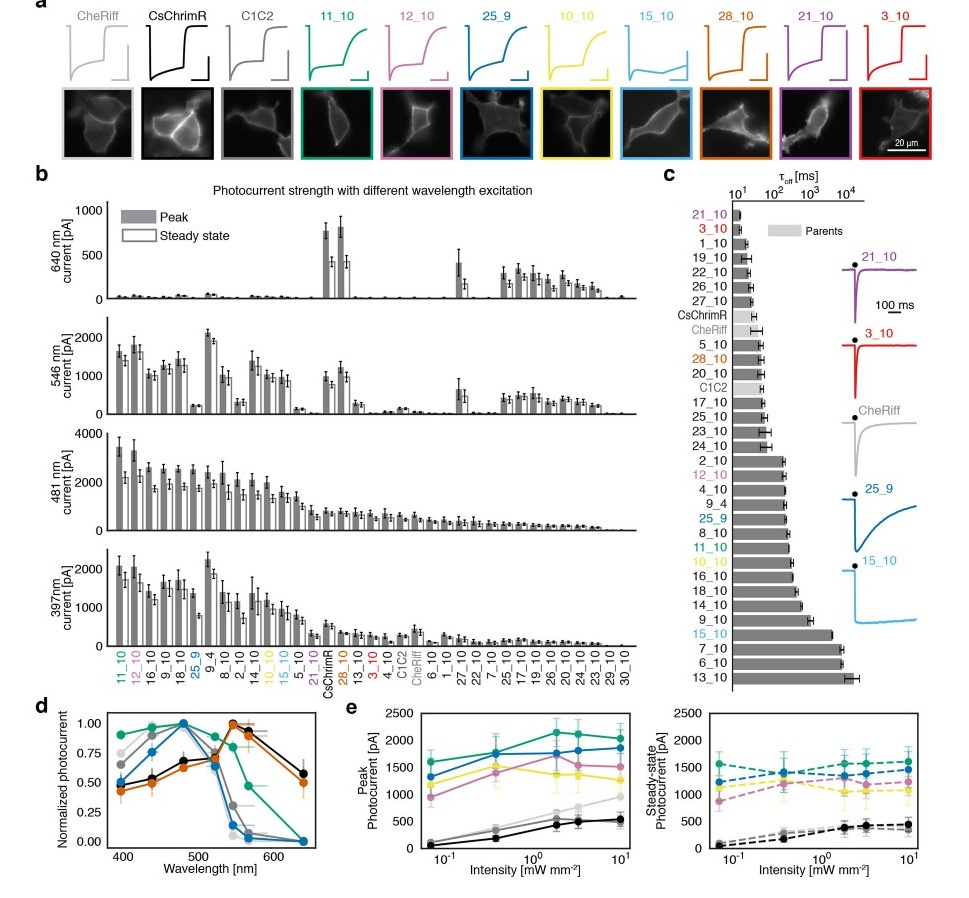

In [20]:
source_figure

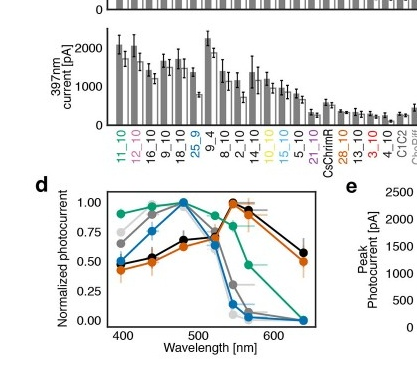

In [21]:
# use pillow to crop the image
fig_size = source_figure.size
bbox_px_vals = [bbox_cropped.left_x*fig_size[0], bbox_cropped.upper_y*fig_size[1], bbox_cropped.right_x*fig_size[0], bbox_cropped.lower_y*fig_size[1]]

# Crop the image using the extracted coordinates
cropped_img = source_figure.crop(bbox_px_vals)
cropped_img.save("cropped_img.png")
cropped_img = Image.open("cropped_img.png")
cropped_img

In [22]:
# make image node from cropped image
from plotreader.utils import image_to_base64

# convert PIL image to b64 encoded string
cropped_img_b64 = image_to_base64(cropped_img)

cropped_img_node = ImageNode(
    image=cropped_img_b64,
    image_url=None,
    metadata={
        "fig_refs": [f"Figure {fig_num}{panel.name}"],
    }
)

In [23]:
nodes.append(cropped_img_node)

In [24]:
class PlotInfo(BaseModel):
    plot_name: str = Field(description="The name of the plot")
    information: str = Field(description="Details that could be useful when interpretting to the plot")

class PanelInfo(BaseModel):
    panel_name: str = Field(description="The name of the panel")
    plots: list[PlotInfo] = Field(description="The plots in the panel")

class FigureInfo(BaseModel):
    figure_name: str = Field(description="The name of the figure")
    panels: list[PanelInfo] = Field(description="The panels in the figure")


In [25]:
output_parser = PydanticOutputParser(output_cls=PlotInfo)

In [26]:
# # let's try to consolidate the context into a summary and add important info we should consider for this figure
# FIGURE_SUMMARY_PROMPT = """
# You will be provided with Figure {fig_num} from a scientific paper, the relevant text from that paper regarding the figure, and a structured representation of the experiments in the plots of that figure.
# Your job is to consolidate information about the figure from the text and image with a focus on quantitative information about the variables in the experiments.
# The most important thing is that you include all quantitative information about the variables in the experiments from the text. DO NOT SUMMARIZE SETS OF QUANTITIES.
# The goal is to use this information in place of the original text (though the image will always be available).
# If there are discrepancies, ambiguities, or potential type-os in source text, resolve in a manner that matches the information to the structured represenation of the figure below.

# Structured representation of the figure:
# {figure_desc_str}

# Retrieved text information:
# {context}
# """

# context = "\n\n".join(
#     [r.get_content(metadata_mode=MetadataMode.LLM) for r in nodes]
# )

# prompt = PromptTemplate(
#     FIGURE_SUMMARY_PROMPT.format(fig_num=fig_num, figure_desc_str=fig_description, context=context),
# ).format(llm=plotreader._MM_LLM)


In [27]:
from llama_index.postprocessor.cohere_rerank import CohereRerank
from llama_index.core.schema import QueryBundle

In [29]:
# let's try to consolidate the context into a summary and add important info we should consider for this figure
FIGURE_SUMMARY_PROMPT = """
You will be provided with a full Figure {fig_num} from a scientific paper, a cropped version with a panel of interest ({panel_name}), and retrieved text from that paper regarding the figure.
Your job is to extract all detailed information about the experimental variables used in a particular plot in the panel: {plot_name}.
The most important thing is that you include all details about the variables in the experiments from the text. DO NOT SUMMARIZE SETS OF QUANTITIES.
You should ensure that the information is only referencing the plot of interesting by looking at the images, but only use this to filter information from the next, not to change it.
IMPORTANT:
    WHEN REFERENCING STYLE ATTRIBUTUES USE STRINGS THAT ARE COMPATIBLE WITH PLOTTING (e.g. 'o' for circles, RGB values for colors)
""".format(fig_num=fig_num, panel_name=panel.name, plot_name=plot.name)
FULL_PROMPT = FIGURE_SUMMARY_PROMPT + """

Structured representation of the plot experiment:
{plot_desc}

Retrieved text information regarding the figure as a whole:
{context}
"""

plot_desc = f"Plot: {plot.name}"
for experiment in plot.experiments:
    plot_desc += f"\n\t{experiment}"

text_nodes = [r for r in nodes if isinstance(r,NodeWithScore) and isinstance(r.node, TextNode)]
cohere_rerank = CohereRerank(top_n=10)
rerankded_text_nodes = cohere_rerank.postprocess_nodes(text_nodes, query_bundle=QueryBundle(query_str=FIGURE_SUMMARY_PROMPT))

context = "\n\n".join(
    [r.get_content(metadata_mode=MetadataMode.LLM) for r in rerankded_text_nodes]
)

full_prompt_formatted = FULL_PROMPT.format(plot_desc=plot_desc, context=context)
prompt = PromptTemplate(
    full_prompt_formatted,
).format(llm=plotreader._MM_LLM)


In [30]:
response = claude_mm_default.message(
    prompt,
    images = [source_figure]
)

In [31]:
details_text =response.content[0].text

In [32]:
print(response.content[0].text)

Based on the provided information and images, here are the details about the experimental variables used in the normalized photocurrent vs wavelength plot (panel d):

Independent variables:
1. Wavelength (nm)
   - Range: 400 nm to 600 nm
   - Categorical: False

2. ChR variant
   - Categorical: True
   - Variants shown:
     - CheRiff (gray)
     - CsChrimR (black)
     - C1C2 (gray)
     - 11_10 (cyan)
     - 12_10 (magenta)
     - 25_9 (light blue)

Dependent variable:
1. Normalized photocurrent
   - Range: 0 to 1
   - Categorical: False

Additional experimental details:
- Light pulse duration: 0.5 s
- Light intensity: 1.3 mW mm^-2 (matched across wavelengths)
- Measurements taken at seven different wavelengths:
  1. 397 ± 3 nm (violet)
  2. 439 ± 8 nm (blue)
  3. 481 ± 3 nm (cyan)
  4. 523 ± 6 nm (teal)
  5. 546 ± 16 nm (green)
  6. 567 ± 13 nm (yellow)
  7. 640 ± 3 nm (red)
- Number of cells measured:
  - CheRiff: n = 6 cells
  - CsChrimR: n = 5 cells
  - C1C2: n = 4 cells
  - 11_1

In [47]:

class CategoricalVariable(BaseModel):
    name: str
    label_type: str = Field(
        ...,
        description="What type of visual signifier is used to label this class in the plot (e.g. color, markertype, etc.)"
    )
    values: dict[str, Union[str, list[float]]] = Field(
        ...,
        description="A map from Category > Label that can act as a legend for this variable. If the label is color, give the RGB value as a list of float."
    )

class NumericVariable(BaseModel):
    name: str
    values: list[float]
    unit: str

In [46]:


plot_struct_str = f"Plot: {plot.name}"
for experiment in plot.experiments:
    plot_struct_str += f"\n\t{experiment}"

ivs_with_values = []

for iv in exp.independent_variables:

    print(iv)
    if iv.categorical:

        var_cls = CategoricalVariable
        prompt = f"""
In Figure {fig_num}{panel.name}, plot title: {plot.name}, what values are taken by the independent variable {iv.name}?
To help you, I've provided information extracted from the text and images of the figure and plot.

IMPORTANT: 
    DO NOT CONFOUND THE VALUES OF AN AXIS WITH THE VALUES OF THE DATA POINT MARKERS. IT IS THE LATTER THAT WE CARE ABOUT.
    THE PROVIDED IMAGE IS A PADDED CROPPING OF THE PANEL OF INTEREST FROM THE FULL FIGURE, PLEASE IGNORE INFORMATION FROM NEARBY PANELS IN THE PADDING.

INFORMATIN FROM TEXT:
{details_text}

Return your answer as structured data.
"""
        
    else:
        var_cls = NumericVariable
        prompt = f"""
In Figure {fig_num}{panel.name}, plot title: {plot.name}, what values are taken by the independent variable {iv.name}?
To help you, I've provided information extracted from the text and images of the figure and plot.

IMPORTANT: 
    DO NOT CONFOUND THE VALUES OF AN AXIS WITH THE VALUES OF THE DATA POINT MARKERS. IT IS THE LATTER THAT WE CARE ABOUT.
    THE PROVIDED IMAGE IS A PADDED CROPPING OF THE PANEL OF INTEREST FROM THE FULL FIGURE, PLEASE IGNORE INFORMATION FROM NEARBY PANELS IN THE PADDING.

INFORMATIN FROM TEXT:
{details_text}

Return your answer as structured data.
        """

    # prompt = f"""In Figure 2, what categories are shown for the independent variable: {exp.independent_variables[1].name}?

    # What categories are shown in this plot for the independent variable: {exp.independent_variables[1].name}?

    # {our_info}
    # """

    output_parser = PydanticOutputParser(output_cls=var_cls)
    prompt = PromptTemplate(prompt, output_parser=output_parser).format(llm=plotreader._MM_LLM)

    response = claude_mm_default.message(
        prompt,
        images = [source_figure, cropped_img]
    )
    text = response.content[0].text

    ivs_with_values.append(output_parser.parse(text))
# print(var_struct)


name='Wavelength' categorical=False
name='ChR variant' categorical=True


In [48]:
ivs_with_values

[NumericVariable(name='Wavelength', values=[397.0, 439.0, 481.0, 523.0, 546.0, 567.0, 640.0], unit='nm'),
 CategoricalVariable(name='ChR variant', label_type='color', values={'CheRiff': [128.0, 128.0, 128.0], 'CsChrimR': [0.0, 0.0, 0.0], 'C1C2': [128.0, 128.0, 128.0], '11_10': [0.0, 255.0, 255.0], '12_10': [255.0, 0.0, 255.0], '25_9': [173.0, 216.0, 230.0]})]

In [49]:
# detailed_plot_desc = plot_desc
# detailed_plot_desc += "\n\t\t\tIndependent Variables Details:"
# for iv in ivs_with_values:
#     detailed_plot_desc += f"\n\t\t\t\t{iv}"

# print(detailed_plot_desc)

Plot: Normalized photocurrent vs wavelength
	independent_variables=[Variable(name='Wavelength', categorical=False), Variable(name='ChR variant', categorical=True)] dependent_variables=[Variable(name='Normalized photocurrent', categorical=False)]
			Independent Variables Details:
				name='Wavelength' values=[397.0, 439.0, 481.0, 523.0, 546.0, 567.0, 640.0] unit='nm'
				name='ChR variant' label_type='color' values={'CheRiff': [128.0, 128.0, 128.0], 'CsChrimR': [0.0, 0.0, 0.0], 'C1C2': [128.0, 128.0, 128.0], '11_10': [0.0, 255.0, 255.0], '12_10': [255.0, 0.0, 255.0], '25_9': [173.0, 216.0, 230.0]}


In [53]:
# # let's try to consolidate the context into a summary and add important info we should consider for this figure
# FIGURE_SUMMARY_PROMPT = """
# Are there any clear errors in this structured description of the data in Figure {fig_num}{panel_name}, plot {plot_name} when looking at the images of the plot?
# We do not care about small differences that don't affect the interpretation of the data (like small differences in the exact values of the variables).

# Here is some context to help you:

# {detailed_plot_desc}
# """

# prompt = FIGURE_SUMMARY_PROMPT.format(
#     fig_num=fig_num, panel_name=panel.name, plot_name=plot.name, detailed_plot_desc=detailed_plot_desc
#     ).replace("{","{{").replace("}","}}")
# prompt = PromptTemplate(
#     prompt,
# ).format(llm=plotreader._MM_LLM)


In [54]:
print(prompt)


Are there any clear errors in this structured description of the data in Figure 2d, plot Normalized photocurrent vs wavelength when looking at the images of the plot?
We do not care about small differences that don't affect the interpretation of the data (like small diffs in quantity or quality).

Plot: Normalized photocurrent vs wavelength
	independent_variables=[Variable(name='Wavelength', categorical=False), Variable(name='ChR variant', categorical=True)] dependent_variables=[Variable(name='Normalized photocurrent', categorical=False)]
			Independent Variables Details:
				name='Wavelength' values=[397.0, 439.0, 481.0, 523.0, 546.0, 567.0, 640.0] unit='nm'
				name='ChR variant' label_type='color' values={'CheRiff': [128.0, 128.0, 128.0], 'CsChrimR': [0.0, 0.0, 0.0], 'C1C2': [128.0, 128.0, 128.0], '11_10': [0.0, 255.0, 255.0], '12_10': [255.0, 0.0, 255.0], '25_9': [173.0, 216.0, 230.0]}



In [55]:
# response = claude_mm_default.message(
#     prompt,
#     images = [cropped_img, source_figure]
# )
# print(response.content[0].text)
# data_revision_response = response.content[0].text

After examining the image of Figure 2d, there are a few clear errors in the structured description provided:

1. Wavelength values: The description lists 7 wavelength values, but the plot only shows 6 data points for each line. The wavelengths on the x-axis are approximately 400, 450, 500, 550, 600, and 650 nm.

2. ChR variant colors: The colors listed in the description don't match exactly with those in the image. For example:
   - CheRiff is shown in gray, not [128, 128, 128]
   - 11_10 is shown in teal/cyan, not [0, 255, 255]
   - 12_10 is shown in magenta/purple, not [255, 0, 255]
   - 25_9 is shown in green, not [173, 216, 230]

3. Missing variants: The description doesn't include all the ChR variants shown in the plot. It's missing at least one orange line that appears in the graph.

4. Y-axis range: The description doesn't mention that the y-axis (Normalized photocurrent) ranges from 0 to 1.00.

These discrepancies could significantly affect the interpretation of the data, espec

In [38]:
# let's try to consolidate the context into a summary and add important info we should consider for this figure
FIGURE_SUMMARY_PROMPT = """
Your job is to extract the independent variables used in a particular plot in the panel: {fig_num}{panel_name} - {plot_name}.
You will be provided with an image cropped around the plot of interest.
The most important thing is that you include all details about the indepedent variables in the experiments from the text. DO NOT SUMMARIZE SETS OF QUANTITIES. DO NOT REFERENCE FIGURE OR PANEL NAMES IN YOUR RESPONSE.
You may need to look to the provided information for clues about the values of the independent variables.
IMPORTANT: 
    DO NOT CONFOUND THE VALUES OF AN AXIS WITH THE VALUES OF THE DATA POINT MARKERS. IT IS THE LATTER THAT WE CARE ABOUT.
    THE PROVIDED IMAGE IS A PADDED CROPPING OF THE PANEL OF INTEREST FROM THE FULL FIGURE, PLEASE IGNORE INFORMATION FROM NEARBY PANELS IN THE PADDING.
    WHEN REFERENCING STYLE ATTRIBUTUES USE STRINGS THAT ARE COMPATIBLE WITH PLOTTING (e.g. 'o' for circles, RGB values for colors)

Structured representation of the plot experiment:
{plot_desc} 

Context parsed directly from figure:
{fig_parsed_text}

"""

plot_desc = f"Plot: {plot.name}"
for experiment in plot.experiments:
    plot_desc += f"\n\t{experiment}"


prompt = PromptTemplate(
    FIGURE_SUMMARY_PROMPT.format(fig_num=fig_num, panel_name=panel.name, plot_name=plot.name, plot_desc=plot_desc, fig_parsed_text=source_figure_summary),
).format(llm=plotreader._MM_LLM)


In [39]:
print(prompt)


Your job is to extract the independent variables used in a particular plot in the panel: 2d - Normalized photocurrent vs wavelength.
You will be provided with an image cropped around the plot of interest.
The most important thing is that you include all details about the indepedent variables in the experiments from the text. DO NOT SUMMARIZE SETS OF QUANTITIES. DO NOT REFERENCE FIGURE OR PANEL NAMES IN YOUR RESPONSE.
You may need to look to the provided information for clues about the values of the independent variables.
IMPORTANT: 
    DO NOT CONFOUND THE VALUES OF AN AXIS WITH THE VALUES OF THE DATA POINT MARKERS. IT IS THE LATTER THAT WE CARE ABOUT.
    THE PROVIDED IMAGE IS A PADDED CROPPING OF THE PANEL OF INTEREST FROM THE FULL FIGURE, PLEASE IGNORE INFORMATION FROM NEARBY PANELS IN THE PADDING.
    WHEN REFERENCING STYLE ATTRIBUTUES USE STRINGS THAT ARE COMPATIBLE WITH PLOTTING (e.g. 'o' for circles, RGB values for colors)

Structured representation of the plot experiment:
Plot

In [40]:
response = claude_mm_default.message(
    prompt,
    images = [cropped_img, source_figure]
)

In [41]:
image_details = response.content[0].text

In [42]:
print(response.content[0].text)

Based on the provided image and context, the independent variables for the normalized photocurrent vs wavelength plot are:

1. Wavelength: The x-axis shows wavelengths ranging from 400 nm to 600 nm.

2. ChR variant: Multiple ChR variants are represented by different colored lines:
   - CheRiff: Gray
   - C1C2: Gray
   - CsChrimR: Black
   - 11_10: Cyan
   - 12_10: Magenta
   - 25_9: Light blue
   - 10_10: Yellow
   - 15_10: Blue
   - 28_10: Orange
   - 21_10: Purple
   - 3_10: Red

The plot shows data points at specific wavelengths (400 nm, 500 nm, 550 nm, 600 nm) for each ChR variant, connected by lines. The y-axis represents the normalized photocurrent, with values ranging from 0 to 1.


In [62]:
iv.values.values()

dict_values([[128.0, 128.0, 128.0], [0.0, 0.0, 0.0], [128.0, 128.0, 128.0], [0.0, 255.0, 255.0], [255.0, 0.0, 255.0], [173.0, 216.0, 230.0], [255.0, 255.0, 0.0]])

/var/folders/0w/7p0llwyd0n39my8_dt311mtr0000gn/T/ipykernel_28500/2638073423.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes.set_xticklabels(axes.get_xticklabels(), rotation=45, ha='right')


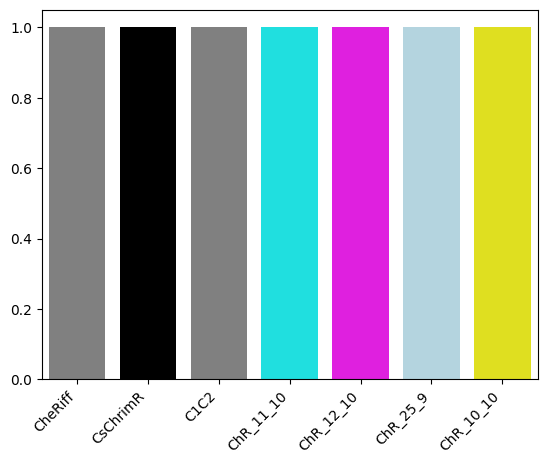

In [63]:
for iv in ivs_with_values:
    if isinstance(iv, CategoricalVariable):
        
        axes = sns.barplot(
            x = iv.values.keys(),
            y = np.ones(len(iv.values.keys())),
            hue = iv.values.keys(),
            palette = [np.array(v)/255 for v in iv.values.values()]
        )
        # rotate x-labels
        axes.set_xticklabels(axes.get_xticklabels(), rotation=45, ha='right')

        # show axes
    else:
        axes = sns.lineplot(
            x = iv.values,
            y = np.ones(len(iv.values)),
            marker = 'o',
        )
    

In [67]:
ivs_with_values_rev = []
for iv in ivs_with_values:
    IV_DETAILS_REVISION_PROMPT = """
We have previously extracted the information about the independent variable {var_name} and their values from Figure {fig_num}{panel_name}, plot {plot_name} using the structure provided below.
We have also found issues with that initial response. 
Given the inital response, the identified issues, and images of the source figure and plot, please revise the initial response.
IMPORTANT: 
    DO NOT CONFOUND THE VALUES OF AN AXIS WITH THE VALUES OF THE DATA POINT MARKERS. IT IS THE LATTER THAT WE CARE ABOUT.
    THE PROVIDED IMAGE IS A PADDED CROPPING OF THE PANEL OF INTEREST FROM THE FULL FIGURE, PLEASE IGNORE INFORMATION FROM NEARBY PANELS IN THE PADDING.

PREVIOUS RESPONSE:
{prev_response}

REVISION ADVICE:
{revision_advice}
""".format(
        var_name = iv.name,
        fig_num = fig_num,
        panel_name = panel.name, 
        plot_name = plot.name,
        prev_response = iv,
        revision_advice = data_revision_response,
    ).replace("{","{{").replace("}","}}")
    if isinstance(iv, CategoricalVariable):
        output_parser = PydanticOutputParser(output_cls=CategoricalVariable)
    else:
        output_parser = PydanticOutputParser(output_cls=NumericVariable)

    prompt = PromptTemplate(IV_DETAILS_REVISION_PROMPT, output_parser=output_parser).format(llm=plotreader._MM_LLM)

    response = claude_mm_default.message(
        prompt,
        images = [source_figure, cropped_img]
    )
    text = response.content[0].text

    ivs_with_values_rev.append(output_parser.parse(text))



In [68]:
ivs_with_values_rev

[NumericVariable(name='Wavelength', values=[400.0, 450.0, 500.0, 550.0, 600.0, 650.0], unit='nm'),
 CategoricalVariable(name='ChR variant', label_type='color', values={'CheRiff': [128.0, 128.0, 128.0], 'CsChrimR': [0.0, 0.0, 0.0], 'C1C2': [128.0, 128.0, 128.0], 'ChR_11_10': [0.0, 255.0, 255.0], 'ChR_12_10': [255.0, 0.0, 255.0], 'ChR_25_9': [0.0, 128.0, 255.0], 'ChR_10_10': [255.0, 255.0, 0.0]})]

In [ ]:
ivs_to_use = ivs_with_values

In [ ]:
output_parser = PydanticOutputParser(output_cls=DataFrameRowsOnly)


columns = {iv.name: pd.Series() for iv in exp.independent_variables}
dep_var = exp.dependent_variables[0]
columns.update({dep_var.name: pd.Series()})
df = pd.DataFrame(columns)

prompt_base = """
In Figure {fig_num}{panel_name}, plot {plot_name}, what are the values for the dependent variable {dep_var_name}?
Get the value for each condition. To help, here is our current belief on the independent variables and their values for this plot:
{ind_vars}


Return your data using the following column schema: {schema}.
""".format(
    fig_num = fig_num,
    panel_name = panel.name, 
    # dep_var_stat = dep_var.statistics[0],
    plot_name = plot.name,
    dep_var_name = dep_var.name,
    ind_vars = "\n".join([str(iv) for iv in ivs_to_use]),
    schema = ", ".join(df.columns),
).replace("{","<").replace("}",">")

prompt = PromptTemplate(prompt_base, output_parser=output_parser).format(llm=plotreader._MM_LLM)

data_response = claude_mm_default.message(
    prompt,
    images = [source_figure, cropped_img]
)
panel_df = output_parser.parse(data_response.content[0].text).to_df(existing_df=df)


/Users/loyalshababo/dev/plotreader/plotreader/utils/structured_types/data.py:61: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return pd.concat([existing_df, new_df], ignore_index=True)


In [ ]:
panel_df_noise = panel_df.copy()
panel_df_noise['Normalized photocurrent'] = panel_df_noise['Normalized photocurrent'] + np.random.normal(0, np.var(panel_df_noise['Normalized photocurrent'])/2, len(panel_df_noise))


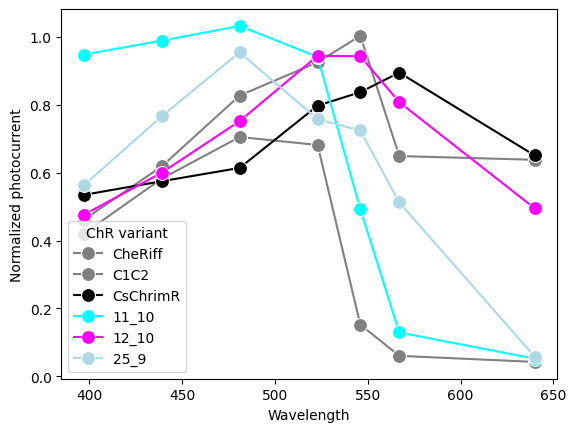

In [ ]:
chr_variant_iv = [iv for iv in ivs_to_use if iv.name == 'ChR variant'][0]
chr_variant_order = [k for k,v in chr_variant_iv.values.items() if k in panel_df['ChR variant'].unique()]
palette = [np.array(v)/255 for k,v in chr_variant_iv.values.items() if k in chr_variant_order]

axes = sns.lineplot(
    data=panel_df_noise,
    x='Wavelength',
    y='Normalized photocurrent',
    hue='ChR variant',
    marker='o',
    hue_order=chr_variant_order,
    markersize=10,
    palette=palette
)
